In [1]:
import pymysql
from sqlalchemy import create_engine
import pandas as pd
import getpass  # To get the password without showing the input
password = getpass.getpass()

········


In [2]:
connection_string = 'mysql+pymysql://root:' + password + '@localhost/sakila'
engine = create_engine(connection_string)

Create a query or queries to extract the information you think may be relevant for building the prediction model. It should include some film features and some rental features.


Read the data into a Pandas dataframe.


Analyze extracted features and transform them. You may need to encode some categorical variables, or scale numerical variables.


Create a query to get the list of films and a boolean indicating if it was rented last month. This would be our target variable.


Create a logistic regression model to predict this variable from the cleaned data.
Evaluate the results.

In [174]:
df = pd.read_sql_query("select date(rental.rental_date) as rental_date_, film_category.category_id, film.special_features, film.length, film.rating from rental join inventory on inventory.inventory_id = rental.inventory_id join film on inventory.film_id = film.film_id join film_category on film.film_id = film_category.film_id group by inventory.film_id order by rental.rental_date desc", engine)

In [175]:
df.head()

,rental_date_,category_id,special_features,length,rating
0,2005-08-02,10,"Commentaries,Behind the Scenes",176,PG-13
1,2005-08-02,11,"Trailers,Deleted Scenes",71,R
2,2005-08-02,3,Deleted Scenes,111,R
3,2005-08-02,15,"Commentaries,Deleted Scenes,Behind the Scenes",138,G
4,2005-08-02,4,"Trailers,Deleted Scenes",121,PG


In [176]:
df.isna().sum()

rental_date_        0
category_id         0
special_features    0
length              0
rating              0
dtype: int64

In [177]:
df.dtypes

rental_date_        object
category_id          int64
special_features    object
length               int64
rating              object
dtype: object

In [178]:
df["special_features"].unique

<bound method Series.unique of 0                     Commentaries,Behind the Scenes
1                            Trailers,Deleted Scenes
2                                     Deleted Scenes
3      Commentaries,Deleted Scenes,Behind the Scenes
4                            Trailers,Deleted Scenes
                           ...                      
953    Commentaries,Deleted Scenes,Behind the Scenes
954                                         Trailers
955                      Commentaries,Deleted Scenes
956        Trailers,Deleted Scenes,Behind the Scenes
957                   Commentaries,Behind the Scenes
Name: special_features, Length: 958, dtype: object>

In [179]:
df["trailers"] = list(map(lambda x: 1 if "Trailers" in x else 0, df["special_features"]))
df["deleted_scenes"]=list(map(lambda x: 1 if "Deleted" in x else 0, df["special_features"]))
df["behind_scenes"]=list(map(lambda x: 1 if "Behind" in x else 0, df["special_features"]))
df["commentaries"]=list(map(lambda x: 1 if "Commentaries" in x else 0, df["special_features"]))
df = df.drop(["special_features"], axis=1)

In [180]:
df.head()

,rental_date_,category_id,length,rating,trailers,deleted_scenes,behind_scenes,commentaries
0,2005-08-02,10,176,PG-13,0,0,1,1
1,2005-08-02,11,71,R,1,1,0,0
2,2005-08-02,3,111,R,0,1,0,0
3,2005-08-02,15,138,G,0,1,1,1
4,2005-08-02,4,121,PG,1,1,0,0


In [181]:
df['category_id'] = df['category_id'].astype('object')
df["rental_date_"]=df["rental_date_"].astype("datetime64")


In [182]:
df.dtypes

rental_date_      datetime64[ns]
category_id               object
length                     int64
rating                    object
trailers                   int64
deleted_scenes             int64
behind_scenes              int64
commentaries               int64
dtype: object

In [183]:


df["rental_month"]=pd.DatetimeIndex(df["rental_date_"]).month

In [184]:

df["rented_last_month"] = list(map(lambda x : True if x in (7,8) else False, df["rental_month"]))        

In [185]:
df.head()

,rental_date_,category_id,length,rating,trailers,deleted_scenes,behind_scenes,commentaries,rental_month,rented_last_month
0,2005-08-02,10,176,PG-13,0,0,1,1,8,True
1,2005-08-02,11,71,R,1,1,0,0,8,True
2,2005-08-02,3,111,R,0,1,0,0,8,True
3,2005-08-02,15,138,G,0,1,1,1,8,True
4,2005-08-02,4,121,PG,1,1,0,0,8,True


In [186]:
df.shape

(958, 10)

In [187]:
df = df.drop(["rental_date_", "rental_month"], axis=1)

In [188]:
df.head()

,category_id,length,rating,trailers,deleted_scenes,behind_scenes,commentaries,rented_last_month
0,10,176,PG-13,0,0,1,1,True
1,11,71,R,1,1,0,0,True
2,3,111,R,0,1,0,0,True
3,15,138,G,0,1,1,1,True
4,4,121,PG,1,1,0,0,True


In [189]:
df.dtypes

category_id          object
length                int64
rating               object
trailers              int64
deleted_scenes        int64
behind_scenes         int64
commentaries          int64
rented_last_month      bool
dtype: object

In [190]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

C:\Users\Arabella2\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


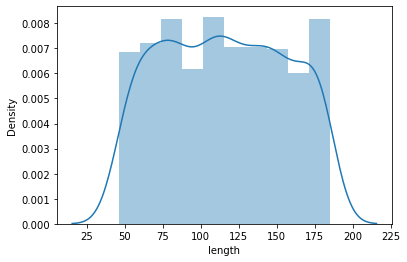

In [191]:
sns.distplot(df['length'])
plt.show()


In [192]:
df.dtypes

category_id          object
length                int64
rating               object
trailers              int64
deleted_scenes        int64
behind_scenes         int64
commentaries          int64
rented_last_month      bool
dtype: object

In [193]:
from sklearn.preprocessing import Normalizer
# from sklearn.preprocessing import StandardScaler
import numpy as np
X = df.select_dtypes(include = np.number)

# Normalizing data
transformer = Normalizer().fit(X)
x_normalized = transformer.transform(X)
x = pd.DataFrame(x_normalized)

In [194]:
cat = df.select_dtypes(include = np.object)
categorical = pd.get_dummies(cat, drop_first=True)

In [195]:
y = df['rented_last_month']
X = np.concatenate((x, categorical), axis=1)

In [211]:
X.shape

(958, 24)

In [206]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100)

In [207]:
from sklearn.linear_model import LogisticRegression
classification = LogisticRegression(random_state=0, solver='lbfgs',
                  multi_class='multinomial').fit(X_train, y_train)

In [208]:
classification.score(X_test, y_test)

0.5833333333333334

In [213]:
predictions = classification.predict(X_test)
pd.Series(predictions).value_counts()

True     193
False     95
dtype: int64

In [214]:
y_test.value_counts()

True     161
False    127
Name: rented_last_month, dtype: int64

In [215]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, predictions)

array([[ 51,  76],
       [ 44, 117]], dtype=int64)

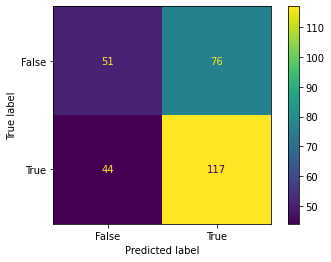

The Kappa of your model is: 0.13


In [218]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import cohen_kappa_score
plot_confusion_matrix(classification, X_test, y_test)  # doctest: +SKIP
plt.show()
print("The Kappa of your model is: %4.2f" % (cohen_kappa_score(y_test, predictions)))